In [2]:
pwd

'/gpfs/alpine/bif135/proj-shared/rbd_work/dask_testing/Min_and_analysis/as_clean_as_it_gets'

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib import cm
import itertools
import numpy as np
import pandas
from datetime import datetime
import copy
from pathlib import Path

In [4]:
temp_dict = {'batch_start': 0,
             'batch_end': 0, 
             'client_start': 0,
             'client_end': 0, 
             'total_time': 0., 
             'client_start_overhead': [], 
             'worker_between_overhead': [], 
             'worker_idle_times': [],
             'stop_overhead': 0}

In [5]:
node_dict = {}

In [11]:
subdir = 's_divinum_64nodes'
node_dict[subdir] = copy.deepcopy(temp_dict)

start_time   = 'Thu Aug 18 05:26:36 EDT 2022'
end_time     = 'Thu Aug 18 07:26:52 EDT 2022'
#client_start = 1660753705.9200435
#client_end   = 1660753772.1873257

st = datetime.strptime(start_time, "%a %b %d %H:%M:%S %Z %Y")
et = datetime.strptime(end_time,   "%a %b %d %H:%M:%S %Z %Y")
total_time = (et - st).total_seconds()
print(st.timestamp())
print(et.timestamp())
node_dict[subdir]['batch_start'] = 0
node_dict[subdir]['batch_end'] = et.timestamp() - st.timestamp()
node_dict[subdir]['client_start'] = 15
node_dict[subdir]['client_end'] = et.timestamp() - st.timestamp()

1660814796.0
1660822012.0


In [12]:
df = pandas.read_csv(f'{subdir}/timings.csv', sep=',')
df['start_time'] -= st.timestamp()
df['stop_time']  -= st.timestamp()
df = df.sort_values(by = ['start_time'])

preprocessing_tasks = df[df['task'] == 'preprocessing']
processing_tasks = df[df['task'] == 'processing']
postprocessing_tasks = df[df['task'] == 'postprocessing']

cpu_workers = list(set(preprocessing_tasks['workerID']))
gpu_workers = list(set(processing_tasks['workerID']))
print(len(cpu_workers),len(gpu_workers))

cpu_worker_client_startup_overheads = []
cpu_worker_between_overheads = []
cpu_worker_idle_times = []
for cpu_worker in cpu_workers:
    cpu_worker_tasks = df[df['workerID'] == cpu_worker]
    a = np.min(cpu_worker_tasks['start_time']) - node_dict[subdir]['client_start']
    b = node_dict[subdir]['client_end'] - np.max(cpu_worker_tasks['stop_time'])
    cpu_worker_client_startup_overheads.append(a)
    cpu_worker_idle_times.append(b)
    between_time = 0
    for i in range(len(cpu_worker_tasks)-1):
        between_time += cpu_worker_tasks.iloc[i+1]['start_time'] - cpu_worker_tasks.iloc[i]['stop_time']
    cpu_worker_between_overheads.append(between_time)
    #print(a,b,between_time)
        
node_dict[subdir]['client_start_overhead'].append(cpu_worker_client_startup_overheads)
node_dict[subdir]['worker_idle_times'].append(cpu_worker_idle_times)
node_dict[subdir]['worker_between_overhead'].append(cpu_worker_between_overheads)

gpu_worker_client_startup_overheads = []
gpu_worker_between_overheads = []
gpu_worker_idle_times = []
for gpu_worker in gpu_workers:
    gpu_worker_tasks = df[df['workerID'] == gpu_worker]
    a = np.min(gpu_worker_tasks['start_time']) - node_dict[subdir]['client_start']
    b = node_dict[subdir]['client_end'] - np.max(gpu_worker_tasks['stop_time'])
    gpu_worker_client_startup_overheads.append(a)
    gpu_worker_idle_times.append(b)
    between_time = 0
    for i in range(len(gpu_worker_tasks)-1):
        between_time += gpu_worker_tasks.iloc[i+1]['start_time'] - gpu_worker_tasks.iloc[i]['stop_time']
    gpu_worker_between_overheads.append(between_time)
    #print(a,b,between_time)
    
node_dict[subdir]['client_start_overhead'].append(gpu_worker_client_startup_overheads)
node_dict[subdir]['worker_idle_times'].append(gpu_worker_idle_times)
node_dict[subdir]['worker_between_overhead'].append(gpu_worker_between_overheads)

print([node_dict[subdir]['batch_end'],node_dict[subdir]['client_end'],np.max(df['stop_time'])])
total_time = np.max([node_dict[subdir]['batch_end'],node_dict[subdir]['client_end'],np.max(df['stop_time'])])
node_dict[subdir]['total_time'] = total_time
node_dict[subdir]['stop_overhead'] = total_time - np.max(df['stop_time'])
#preprocessing_dt = df['stop_time'] - df['start_time'] if df['task'] == 'preprocessing'

2048 384
[7216.0, 7216.0, 5786.096814632416]


In [13]:
worker_dict = {}
count = 0
for worker in preprocessing_tasks.iloc:
    if worker['workerID'] not in worker_dict.keys():
        worker_dict[worker['workerID']] = count
        count += 1
#print(worker_dict)
print(count)

for worker in processing_tasks.iloc:
    if worker['workerID'] not in worker_dict.keys():
        worker_dict[worker['workerID']] = count
        count += 1
#print(worker_dict)
print(count)

#idx = np.argsort(np.array([task[1] for task in gpu_output]))
#print(idx)
#for i,elem_id in enumerate(idx):
#    worker = gpu_output[elem_id]
#    if worker[0] not in worker_dict.keys():
#        worker_dict[worker[0]] = i + count

#print(worker_dict.items())

2048
2432


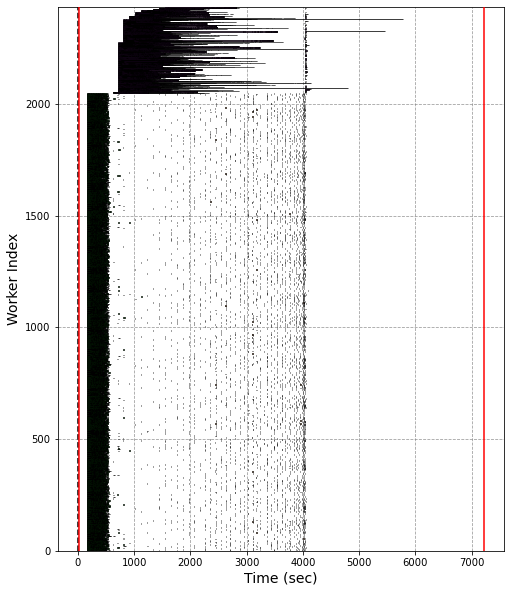

In [14]:
colormap = cm.Dark2.colors
figure = plt.figure(figsize=(8,10))
ax = plt.gca()
#fig, ax = plt.subplots(1)
ax.plot([0,0],[0,count+1],'k--',zorder=3)
ax.plot([node_dict[subdir]['client_start'],node_dict[subdir]['client_start']],[0,count+1],'r-',zorder=3)
ax.plot([total_time,total_time],[0,count+1],'r-',zorder=3)

for task in df.iloc:
    worker_id = worker_dict[task['workerID']]
    if task['task'] == 'preprocessing':
        facecolor = 'xkcd:green'
    elif task['task'] == 'processing':
        facecolor = 'xkcd:purple'
    elif task['task'] == 'postprocessing':
        facecolor = 'xkcd:orange'
    task_rect = Rectangle((task['start_time'], worker_id + 0.6), # xy
                           task['stop_time']-task['start_time'], # width
                           0.8, # height
                           facecolor = facecolor,
                           alpha = 0.75, edgecolor = 'xkcd:black', zorder = 3)
    ax.add_patch(task_rect)

ax.set_ylim((0.,count+1))
#ax.set_xlim((-1.,100))
ax.set_ylabel('Worker Index',size=14)
ax.set_xlabel('Time (sec)',size=14)
plt.grid(b=True,which='major',axis='both',color='#808080',linestyle='--',alpha=0.75,zorder=1)
plt.savefig(f'{subdir}/worker_timeline.png',dpi=600,transparent=True)
plt.show()
plt.close()

In [15]:
print(node_dict.keys())
print(node_dict[subdir].keys())
print(node_dict[subdir]['batch_start'])
print(node_dict[subdir]['batch_end'])
print(node_dict[subdir]['client_start'])
print(node_dict[subdir]['client_end'])
print(node_dict[subdir]['total_time'])
for i in node_dict[subdir]['client_start_overhead']:
    print(np.mean(i),np.std(i),len(i))
for i in node_dict[subdir]['worker_between_overhead']:
    print(np.mean(i),np.std(i),len(i))
for i in node_dict[subdir]['worker_idle_times']:
    print(np.mean(i),np.std(i),len(i))
print(node_dict[subdir]['stop_overhead'])

dict_keys(['s_divinum_64nodes'])
dict_keys(['batch_start', 'batch_end', 'client_start', 'client_end', 'total_time', 'client_start_overhead', 'worker_between_overhead', 'worker_idle_times', 'stop_overhead'])
0
7216.0
15
7216.0
7216.0
141.5084923208924 0.5071069690326961 2048
772.676525661101 144.20551446937318 384
3530.5260859328555 58.05879318819554 2048
1502.2280441491555 1128.2048081761766 384
3187.96433263761 55.08692248461825 2048
3826.2988802703717 1032.982574374637 384
1429.9031853675842


In [53]:
print(np.argmax(df['stop_time'] - df['start_time']))
idx = list(np.argpartition(df['stop_time'] - df['start_time'],-25)[-25:])
print(idx)
print(df.iloc[26400]['file_path'])

26400
[25240, 25187, 74866, 25804, 25253, 25618, 25270, 25438, 25754, 25307, 26167, 25361, 25107, 35435, 29975, 25740, 25388, 26400, 26567, 25375, 25413, 25406, 26784, 26570, 26238]
/gpfs/alpine/bif135/proj-shared/rbd_work/dask_testing/Min_and_analysis/as_clean_as_it_gets/s_divinum_64nodes/Sphm18G066000.1


In [38]:
df.iloc[idx]['stop_time'] - df.iloc[idx]['start_time']

30186    1352.195699
31420    1377.828782
75396    1423.731130
34881    1481.101740
32991    1539.810585
33717    1514.230983
32454    1489.780512
36823    1611.683829
47778    2436.957844
35976    1824.830276
51485    2540.194563
37336    1970.234792
61281    3126.687743
43863    1653.427025
40513    1628.093851
36394    1730.018831
75394    4041.376955
75398    4832.908261
66394    3010.616530
38843    1992.440478
39263    2106.699782
36816    1892.845427
41025    1924.649790
37035    1673.069716
40805    2006.393857
dtype: float64

(-1.0, 900.0)

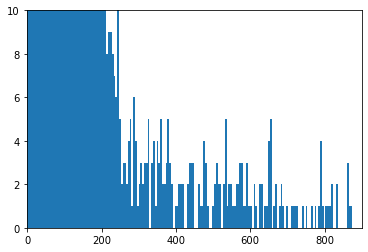

In [50]:
results = plt.hist(df['stop_time'] - df['start_time'],bins=1000)
plt.ylim((0,10))
plt.xlim((-1,900))

In [57]:
with open('remove_structures.lst','w') as lst_file:
    system_list = []
    for task in df.iloc:
        if task['stop_time'] - task['start_time'] > 500.:
            system = Path(task['file_path']).name
            system_list.append(system)
    system_list = list(set(system_list))
    print(len(system_list))
    for system in system_list:
        lst_file.write(f'{system}\n')

151


In [58]:
with open('s_divinum_af_structures.lst','r') as full_list, open('s_divinum_af_structures_minus_151.lst','w') as out_list:
    for line in full_list:
        system = Path(line.split()[0]).parent.name
        if system not in system_list:
            out_list.write(line)
        else: 
            print(f'removing {line}')

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm15G021300.1/model_1_ptm_20211001_576771.pdb    1542

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm13G078700.1/model_1_ptm_20211001_451456.pdb    1527

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm10G076600.1/model_1_ptm_20211002_219353.pdb    2318

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm01G020800.1/model_2_ptm_20210930_278748.pdb    1833

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm12G060200.1/model_1_ptm_20210930_226721.pdb    2173

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm04G114900.1/model_3_ptm_20210924_504779.pdb    1394

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm13G060400.1/model_1_ptm_20210930_331580.pdb    2174

removing /gpfs/alpine/bif135/world-shared/species/smagellanicum/af_mod/Sphm02G088100.1/model_3_ptm_20210

In [62]:
import glob
[Path(f).parent for f in glob.glob('*/timings.csv')]

[PosixPath('subset2_08nodes'),
 PosixPath('subset2_02nodes'),
 PosixPath('subset2_01nodes'),
 PosixPath('subset2_16nodes'),
 PosixPath('s_divinum_016nodes'),
 PosixPath('subset2_04nodes')]